In [1]:
# AeroCNN-I
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import datetime
%matplotlib inline

In [2]:
n_units=512
l2Regularizer=1e-09
kernel_size = 2
n_grid = 101
strides = 2
input_size = 49

In [3]:
alpha = np.linspace(-10,20,16).reshape((16,1))

In [4]:
aa = np.zeros((16*133,1))
for i in range(0, 133):
    aa[16*i:16*(i+1), :] = alpha[:,:]

In [5]:
aa = aa.reshape((133, 16, 1, 1))

In [6]:
os.chdir('D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out')

In [7]:
origin = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [8]:
folders_orig = os.listdir(origin_data)
folders = [file for file in folders_orig if file.startswith('airfoil')]

In [9]:
coord_df = pd.DataFrame()
counter = 1
for i in range(1, 134):
    coord_file_name = origin_coord + "\\airfoil" + str(i) + "\\airfoilOut"+ str(i) + ".txt"
    data = pd.read_csv(coord_file_name, sep = ",", header=None)
    while counter < 17:
        coord_df = pd.concat([coord_df, data], axis=0)
        counter += 1
    counter=1

In [10]:
coord_np = coord_df.iloc[:, :].values

In [11]:
coord = coord_np.reshape((len(folders), 16, 2, 50))

In [12]:
cl_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cl_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cl_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cl_name, sep = ",", header=None)
        cl_df = pd.concat([cl_df, data], axis=0)

In [13]:
cd_df = pd.DataFrame()
for i in range(1, 134):
    for alpha_ in alpha:
        cd_name = origin_coord + "\\airfoil" + str(i) + "\\"+ str(int(alpha_)) + "\\Cd_" + str(i) + "_"+ str(int(alpha_)) +".txt"
        data = pd.read_csv(cd_name, sep = ",", header=None)
        cd_df = pd.concat([cd_df, data], axis=0)

In [14]:
cl = cl_df.iloc[:, :].values.reshape((-1,1))
cd = cd_df.iloc[:, :].values.reshape((-1,1))
y = np.hstack((cl, cd))

In [15]:
y = y.reshape((133, 16, 2, 1))

In [16]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 1].values

In [17]:
geometry = np.zeros((133*16,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig:
    index_ = np.where(geometry_orig==i)
    for j in range(0,16):
        geometry[16*index_[0]+j,:] = np.asarray(i)

In [18]:
geometry.shape

(2128, 1)

In [19]:
geometry = geometry.reshape((133, 16, 1))

In [20]:
x_train, x_test, aa_train, aa_test, geo_train, geo_test, y_train, y_test = train_test_split(coord, aa, geometry, y, test_size=0.3, random_state=1)

In [21]:
x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3]))
x_test = x_test.reshape((x_test.shape[0]*x_test.shape[1], x_test.shape[2], x_test.shape[3]))
aa_train = aa_train.reshape((aa_train.shape[0]*aa_train.shape[1], aa_train.shape[2], aa_train.shape[3]))
aa_test = aa_test.reshape((aa_test.shape[0]*aa_test.shape[1], aa_test.shape[2], aa_test.shape[3]))
geo_train = geo_train.reshape((geo_train.shape[0]*geo_train.shape[1], geo_train.shape[2]))
geo_test = geo_test.reshape((geo_test.shape[0]*geo_test.shape[1], geo_test.shape[2]))
y_train = y_train.reshape((y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3]))
y_test = y_test.reshape((y_test.shape[0]*y_test.shape[1], y_test.shape[2], y_test.shape[3]))

In [23]:
input_coord = tf.keras.Input(shape=(2, 50))
input_alpha = tf.keras.Input(shape=(1,1))
flatten = tf.keras.layers.Flatten()(input_coord)
reshape1 = tf.keras.layers.Reshape((1,))(input_alpha)
x_concat = tf.keras.layers.Concatenate(axis=1)([flatten, reshape1])

x_ = tf.keras.layers.Dense(units=200, activation='relu', name='firstHiddenLayerSensor',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_concat)
x_ = tf.keras.layers.Dense(units=100, activation='relu', name='secondHiddenLayerSensor',
                           kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_)
output_data = tf.keras.layers.Dense(units=2, activation=None, name='outputLayerSensor')(x_)
output_coeff = tf.keras.layers.Reshape((2, 1))(output_data)
# MLP
model = tf.keras.Model([input_coord, input_alpha], output_coeff)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2, 50)]      0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1, 1)]       0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 100)          0           ['input_3[0][0]']                
                                                                                                  
 reshape_2 (Reshape)            (None, 1)            0           ['input_4[0][0]']                
                                                                                              

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [26]:
start = datetime.datetime.now()
history = model.fit([x_train,aa_train], y_train, epochs=5000, shuffle=True)
end = datetime.datetime.now()

Epoch 1/5000
47/47 [==============================] - 2s 5ms/step - loss: 0.0430 - rmse: 0.2074
Epoch 2/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0154 - rmse: 0.1239
Epoch 3/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0139 - rmse: 0.1178
Epoch 4/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0115 - rmse: 0.1074
Epoch 5/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0114 - rmse: 0.1069
Epoch 6/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0110 - rmse: 0.1049
Epoch 7/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0117 - rmse: 0.1084
Epoch 8/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0116 - rmse: 0.1079
Epoch 9/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0094 - rmse: 0.0969
Epoch 10/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0105 - rmse: 0.1027
Epoch 11/5000
47/47 [==================

47/47 [==============================] - 0s 5ms/step - loss: 0.0068 - rmse: 0.0822
Epoch 86/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0068 - rmse: 0.0822
Epoch 87/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0075 - rmse: 0.0866
Epoch 88/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0061 - rmse: 0.0778
Epoch 89/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0071 - rmse: 0.0842
Epoch 90/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0062 - rmse: 0.0786
Epoch 91/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0060 - rmse: 0.0775
Epoch 92/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0058 - rmse: 0.0761
Epoch 93/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0064 - rmse: 0.0798
Epoch 94/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0067 - rmse: 0.0822
Epoch 95/5000
47/47 [=======================

47/47 [==============================] - 0s 4ms/step - loss: 0.0048 - rmse: 0.0694
Epoch 169/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0048 - rmse: 0.0689
Epoch 170/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0051 - rmse: 0.0715
Epoch 171/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0052 - rmse: 0.0721
Epoch 172/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0050 - rmse: 0.0704
Epoch 173/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0049 - rmse: 0.0703
Epoch 174/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0047 - rmse: 0.0688
Epoch 175/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0050 - rmse: 0.0705
Epoch 176/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0052 - rmse: 0.0720
Epoch 177/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0049 - rmse: 0.0697
Epoch 178/5000
47/47 [=============

47/47 [==============================] - 0s 5ms/step - loss: 0.0044 - rmse: 0.0665
Epoch 252/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0044 - rmse: 0.0665
Epoch 253/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0050 - rmse: 0.0705
Epoch 254/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0045 - rmse: 0.0672
Epoch 255/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0044 - rmse: 0.0664
Epoch 256/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0043 - rmse: 0.0658
Epoch 257/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0044 - rmse: 0.0660
Epoch 258/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0045 - rmse: 0.0670
Epoch 259/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0044 - rmse: 0.0666
Epoch 260/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0047 - rmse: 0.0682
Epoch 261/5000
47/47 [=============

47/47 [==============================] - 0s 5ms/step - loss: 0.0042 - rmse: 0.0646
Epoch 335/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0040 - rmse: 0.0634
Epoch 336/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0041 - rmse: 0.0642
Epoch 337/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0043 - rmse: 0.0659
Epoch 338/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0043 - rmse: 0.0655
Epoch 339/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0041 - rmse: 0.0638
Epoch 340/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0042 - rmse: 0.0645
Epoch 341/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0039 - rmse: 0.0623
Epoch 342/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0040 - rmse: 0.0634
Epoch 343/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0041 - rmse: 0.0639
Epoch 344/5000
47/47 [=============

47/47 [==============================] - 0s 5ms/step - loss: 0.0039 - rmse: 0.0625
Epoch 418/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0038 - rmse: 0.0620
Epoch 419/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0039 - rmse: 0.0622
Epoch 420/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0039 - rmse: 0.0622
Epoch 421/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0040 - rmse: 0.0631
Epoch 422/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0041 - rmse: 0.0639
Epoch 423/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0039 - rmse: 0.0628
Epoch 424/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0037 - rmse: 0.0611
Epoch 425/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0038 - rmse: 0.0618
Epoch 426/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0039 - rmse: 0.0626
Epoch 427/5000
47/47 [=============

47/47 [==============================] - 0s 4ms/step - loss: 0.0036 - rmse: 0.0599
Epoch 501/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0034 - rmse: 0.0582
Epoch 502/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0035 - rmse: 0.0593
Epoch 503/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0036 - rmse: 0.0596
Epoch 504/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0036 - rmse: 0.0596
Epoch 505/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0036 - rmse: 0.0603
Epoch 506/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0038 - rmse: 0.0614
Epoch 507/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0036 - rmse: 0.0604
Epoch 508/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0033 - rmse: 0.0578
Epoch 509/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0034 - rmse: 0.0581
Epoch 510/5000
47/47 [=============

47/47 [==============================] - 0s 5ms/step - loss: 0.0033 - rmse: 0.0578
Epoch 584/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0032 - rmse: 0.0565
Epoch 585/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0034 - rmse: 0.0583
Epoch 586/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0031 - rmse: 0.0552
Epoch 587/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0030 - rmse: 0.0551
Epoch 588/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0031 - rmse: 0.0553
Epoch 589/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0032 - rmse: 0.0569
Epoch 590/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0032 - rmse: 0.0569
Epoch 591/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0032 - rmse: 0.0568
Epoch 592/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0033 - rmse: 0.0570
Epoch 593/5000
47/47 [=============

47/47 [==============================] - 0s 5ms/step - loss: 0.0030 - rmse: 0.0544
Epoch 667/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0030 - rmse: 0.0546
Epoch 668/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0033 - rmse: 0.0573
Epoch 669/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0031 - rmse: 0.0561
Epoch 670/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0028 - rmse: 0.0528
Epoch 671/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0029 - rmse: 0.0539
Epoch 672/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0028 - rmse: 0.0525
Epoch 673/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0030 - rmse: 0.0547
Epoch 674/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0027 - rmse: 0.0520
Epoch 675/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0028 - rmse: 0.0526
Epoch 676/5000
47/47 [=============

47/47 [==============================] - 0s 4ms/step - loss: 0.0027 - rmse: 0.0518
Epoch 750/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0029 - rmse: 0.0537
Epoch 751/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0028 - rmse: 0.0528
Epoch 752/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0031 - rmse: 0.0561
Epoch 753/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0031 - rmse: 0.0555
Epoch 754/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0026 - rmse: 0.0506
Epoch 755/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0025 - rmse: 0.0499
Epoch 756/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0026 - rmse: 0.0508
Epoch 757/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0026 - rmse: 0.0509
Epoch 758/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0028 - rmse: 0.0526
Epoch 759/5000
47/47 [=============

47/47 [==============================] - 0s 5ms/step - loss: 0.0025 - rmse: 0.0498
Epoch 833/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0024 - rmse: 0.0494
Epoch 834/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0024 - rmse: 0.0492
Epoch 835/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0026 - rmse: 0.0509
Epoch 836/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0026 - rmse: 0.0506
Epoch 837/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0025 - rmse: 0.0502
Epoch 838/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0028 - rmse: 0.0525
Epoch 839/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0026 - rmse: 0.0507
Epoch 840/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0025 - rmse: 0.0499
Epoch 841/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0023 - rmse: 0.0478
Epoch 842/5000
47/47 [=============

47/47 [==============================] - 0s 5ms/step - loss: 0.0024 - rmse: 0.0488
Epoch 916/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0024 - rmse: 0.0486
Epoch 917/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0028 - rmse: 0.0524
Epoch 918/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0027 - rmse: 0.0522
Epoch 919/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0027 - rmse: 0.0518
Epoch 920/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0027 - rmse: 0.0516
Epoch 921/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0024 - rmse: 0.0492
Epoch 922/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0021 - rmse: 0.0460
Epoch 923/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0022 - rmse: 0.0468
Epoch 924/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0024 - rmse: 0.0487
Epoch 925/5000
47/47 [=============

47/47 [==============================] - 0s 5ms/step - loss: 0.0023 - rmse: 0.0483
Epoch 999/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0025 - rmse: 0.0501
Epoch 1000/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0023 - rmse: 0.0477
Epoch 1001/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0024 - rmse: 0.0495
Epoch 1002/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0026 - rmse: 0.0512
Epoch 1003/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0026 - rmse: 0.0510
Epoch 1004/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0023 - rmse: 0.0480
Epoch 1005/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0019 - rmse: 0.0440
Epoch 1006/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0023 - rmse: 0.0474
Epoch 1007/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0021 - rmse: 0.0455
Epoch 1008/5000
47/47 [====

47/47 [==============================] - 0s 4ms/step - loss: 0.0020 - rmse: 0.0446
Epoch 1081/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0021 - rmse: 0.0459
Epoch 1082/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0023 - rmse: 0.0480
Epoch 1083/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0019 - rmse: 0.0432
Epoch 1084/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0020 - rmse: 0.0451
Epoch 1085/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0020 - rmse: 0.0447
Epoch 1086/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0019 - rmse: 0.0439
Epoch 1087/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0019 - rmse: 0.0434
Epoch 1088/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0020 - rmse: 0.0448
Epoch 1089/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0021 - rmse: 0.0459
Epoch 1090/5000
47/47 [===

47/47 [==============================] - 0s 5ms/step - loss: 0.0018 - rmse: 0.0430
Epoch 1163/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0018 - rmse: 0.0427
Epoch 1164/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0418
Epoch 1165/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0411
Epoch 1166/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0414
Epoch 1167/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0020 - rmse: 0.0446
Epoch 1168/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0019 - rmse: 0.0431
Epoch 1169/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0020 - rmse: 0.0442
Epoch 1170/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0021 - rmse: 0.0463
Epoch 1171/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0019 - rmse: 0.0434
Epoch 1172/5000
47/47 [===

47/47 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0417
Epoch 1245/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0016 - rmse: 0.0404
Epoch 1246/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0409
Epoch 1247/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0407
Epoch 1248/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0019 - rmse: 0.0431
Epoch 1249/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0019 - rmse: 0.0440
Epoch 1250/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0019 - rmse: 0.0431
Epoch 1251/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0017 - rmse: 0.0408
Epoch 1252/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0018 - rmse: 0.0425
Epoch 1253/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0407
Epoch 1254/5000
47/47 [===

47/47 [==============================] - 0s 4ms/step - loss: 0.0015 - rmse: 0.0385
Epoch 1327/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0019 - rmse: 0.0440
Epoch 1328/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0021 - rmse: 0.0460
Epoch 1329/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0016 - rmse: 0.0406
Epoch 1330/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0016 - rmse: 0.0404
Epoch 1331/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0016 - rmse: 0.0405
Epoch 1332/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0015 - rmse: 0.0393
Epoch 1333/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0021 - rmse: 0.0461
Epoch 1334/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0418
Epoch 1335/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0019 - rmse: 0.0437
Epoch 1336/5000
47/47 [===

47/47 [==============================] - 0s 5ms/step - loss: 0.0017 - rmse: 0.0411
Epoch 1409/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0019 - rmse: 0.0435
Epoch 1410/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0020 - rmse: 0.0442
Epoch 1411/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0016 - rmse: 0.0393
Epoch 1412/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0018 - rmse: 0.0426
Epoch 1413/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0018 - rmse: 0.0419
Epoch 1414/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0019 - rmse: 0.0432
Epoch 1415/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0015 - rmse: 0.0387
Epoch 1416/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0014 - rmse: 0.0369
Epoch 1417/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0017 - rmse: 0.0414
Epoch 1418/5000
47/47 [===

47/47 [==============================] - 0s 4ms/step - loss: 0.0018 - rmse: 0.0425
Epoch 1491/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0017 - rmse: 0.0407
Epoch 1492/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0014 - rmse: 0.0379
Epoch 1493/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0014 - rmse: 0.0378
Epoch 1494/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0015 - rmse: 0.0382
Epoch 1495/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0014 - rmse: 0.0378
Epoch 1496/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0014 - rmse: 0.0379
Epoch 1497/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0016 - rmse: 0.0395
Epoch 1498/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0015 - rmse: 0.0382
Epoch 1499/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0015 - rmse: 0.0392
Epoch 1500/5000
47/47 [===

47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0367
Epoch 1573/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0014 - rmse: 0.0375
Epoch 1574/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0014 - rmse: 0.0368
Epoch 1575/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0014 - rmse: 0.0368
Epoch 1576/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0355
Epoch 1577/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0016 - rmse: 0.0396
Epoch 1578/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0013 - rmse: 0.0362
Epoch 1579/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0014 - rmse: 0.0369
Epoch 1580/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0018 - rmse: 0.0421
Epoch 1581/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0020 - rmse: 0.0443
Epoch 1582/5000
47/47 [===

47/47 [==============================] - 0s 4ms/step - loss: 0.0014 - rmse: 0.0375
Epoch 1655/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0012 - rmse: 0.0353
Epoch 1656/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0358
Epoch 1657/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0343
Epoch 1658/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0341
Epoch 1659/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0347
Epoch 1660/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0363
Epoch 1661/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0016 - rmse: 0.0401
Epoch 1662/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0356
Epoch 1663/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0013 - rmse: 0.0359
Epoch 1664/5000
47/47 [===

47/47 [==============================] - 0s 5ms/step - loss: 0.0014 - rmse: 0.0379
Epoch 1737/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0364
Epoch 1738/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0012 - rmse: 0.0341
Epoch 1739/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0013 - rmse: 0.0353
Epoch 1740/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0012 - rmse: 0.0346
Epoch 1741/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0011 - rmse: 0.0338
Epoch 1742/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0335
Epoch 1743/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0343
Epoch 1744/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0014 - rmse: 0.0379
Epoch 1745/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0352
Epoch 1746/5000
47/47 [===

47/47 [==============================] - 0s 4ms/step - loss: 0.0014 - rmse: 0.0375
Epoch 1819/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0011 - rmse: 0.0332
Epoch 1820/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0013 - rmse: 0.0353
Epoch 1821/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0014 - rmse: 0.0374
Epoch 1822/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0338
Epoch 1823/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0359
Epoch 1824/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0014 - rmse: 0.0375
Epoch 1825/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0359
Epoch 1826/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0013 - rmse: 0.0366
Epoch 1827/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0014 - rmse: 0.0372
Epoch 1828/5000
47/47 [===

47/47 [==============================] - 0s 4ms/step - loss: 0.0013 - rmse: 0.0367
Epoch 1901/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0014 - rmse: 0.0367
Epoch 1902/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0012 - rmse: 0.0346
Epoch 1903/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0013 - rmse: 0.0361
Epoch 1904/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0014 - rmse: 0.0370
Epoch 1905/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0355
Epoch 1906/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0011 - rmse: 0.0328
Epoch 1907/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0012 - rmse: 0.0345
Epoch 1908/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0011 - rmse: 0.0336
Epoch 1909/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0011 - rmse: 0.0325
Epoch 1910/5000
47/47 [===

47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0325
Epoch 1983/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0328
Epoch 1984/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0351
Epoch 1985/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0014 - rmse: 0.0377
Epoch 1986/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0334
Epoch 1987/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.8874e-04 - rmse: 0.0314
Epoch 1988/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0011 - rmse: 0.0327
Epoch 1989/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0011 - rmse: 0.0337
Epoch 1990/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0329
Epoch 1991/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0337
Epoch 1992/5000
47/47 

47/47 [==============================] - 0s 4ms/step - loss: 0.0014 - rmse: 0.0376
Epoch 2065/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0340
Epoch 2066/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0339
Epoch 2067/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.4841e-04 - rmse: 0.0307
Epoch 2068/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0010 - rmse: 0.0319
Epoch 2069/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0012 - rmse: 0.0347
Epoch 2070/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0011 - rmse: 0.0329
Epoch 2071/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.3547e-04 - rmse: 0.0305
Epoch 2072/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.5973e-04 - rmse: 0.0292
Epoch 2073/5000
47/47 [==============================] - 0s 4ms/step - loss: 9.5039e-04 - rmse: 0.0308
Epoch 2074

47/47 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0316
Epoch 2146/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0351
Epoch 2147/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0350
Epoch 2148/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0322
Epoch 2149/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0333
Epoch 2150/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.7465e-04 - rmse: 0.0311
Epoch 2151/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0317
Epoch 2152/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0316
Epoch 2153/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0340
Epoch 2154/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0337
Epoch 2155/5000
47/47 

Epoch 2227/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.6322e-04 - rmse: 0.0310
Epoch 2228/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0011 - rmse: 0.0329
Epoch 2229/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0319
Epoch 2230/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0347
Epoch 2231/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0352
Epoch 2232/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0356
Epoch 2233/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0322
Epoch 2234/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.7908e-04 - rmse: 0.0296
Epoch 2235/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0337
Epoch 2236/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0322
Ep

47/47 [==============================] - 0s 5ms/step - loss: 7.6208e-04 - rmse: 0.0275
Epoch 2309/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.2833e-04 - rmse: 0.0304
Epoch 2310/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0330
Epoch 2311/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.6754e-04 - rmse: 0.0310
Epoch 2312/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.5161e-04 - rmse: 0.0308
Epoch 2313/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.8269e-04 - rmse: 0.0313
Epoch 2314/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.7759e-04 - rmse: 0.0312
Epoch 2315/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.5070e-04 - rmse: 0.0291
Epoch 2316/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.3713e-04 - rmse: 0.0288
Epoch 2317/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.0911e-04 - rms

47/47 [==============================] - 0s 5ms/step - loss: 9.7895e-04 - rmse: 0.0312
Epoch 2389/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0327
Epoch 2390/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0348
Epoch 2391/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.8573e-04 - rmse: 0.0297
Epoch 2392/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0321
Epoch 2393/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.9992e-04 - rmse: 0.0315
Epoch 2394/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.0322e-04 - rmse: 0.0300
Epoch 2395/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0317
Epoch 2396/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.0470e-04 - rmse: 0.0300
Epoch 2397/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.1286e-04 - rmse: 0.0301
Ep

47/47 [==============================] - 0s 5ms/step - loss: 8.2747e-04 - rmse: 0.0287
Epoch 2469/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0316
Epoch 2470/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0319
Epoch 2471/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.3596e-04 - rmse: 0.0305
Epoch 2472/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.7797e-04 - rmse: 0.0295
Epoch 2473/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.1963e-04 - rmse: 0.0302
Epoch 2474/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.7383e-04 - rmse: 0.0311
Epoch 2475/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.0025e-04 - rmse: 0.0299
Epoch 2476/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.1067e-04 - rmse: 0.0284
Epoch 2477/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.3710e-04 - rmse: 0

47/47 [==============================] - 0s 5ms/step - loss: 8.4933e-04 - rmse: 0.0290
Epoch 2549/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.1354e-04 - rmse: 0.0284
Epoch 2550/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.2381e-04 - rmse: 0.0286
Epoch 2551/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0014 - rmse: 0.0368
Epoch 2552/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0346
Epoch 2553/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0337
Epoch 2554/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.5782e-04 - rmse: 0.0309
Epoch 2555/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.5064e-04 - rmse: 0.0307
Epoch 2556/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0339
Epoch 2557/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0319
Epoch 

47/47 [==============================] - 0s 5ms/step - loss: 8.4687e-04 - rmse: 0.0290
Epoch 2629/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.5832e-04 - rmse: 0.0292
Epoch 2630/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.0718e-04 - rmse: 0.0283
Epoch 2631/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.7914e-04 - rmse: 0.0296
Epoch 2632/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.4436e-04 - rmse: 0.0290
Epoch 2633/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0345
Epoch 2634/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.3298e-04 - rmse: 0.0305
Epoch 2635/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.8001e-04 - rmse: 0.0296
Epoch 2636/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.5356e-04 - rmse: 0.0273
Epoch 2637/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.3332e-04 - rms

47/47 [==============================] - 0s 5ms/step - loss: 9.1577e-04 - rmse: 0.0302
Epoch 2709/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0010 - rmse: 0.0318
Epoch 2710/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.1575e-04 - rmse: 0.0302
Epoch 2711/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.9218e-04 - rmse: 0.0298
Epoch 2712/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.6371e-04 - rmse: 0.0275
Epoch 2713/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.1983e-04 - rmse: 0.0267
Epoch 2714/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.4134e-04 - rmse: 0.0289
Epoch 2715/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.0972e-04 - rmse: 0.0284
Epoch 2716/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.1038e-04 - rmse: 0.0301
Epoch 2717/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.6328e-04 - rms

47/47 [==============================] - 0s 5ms/step - loss: 8.4256e-04 - rmse: 0.0289
Epoch 2789/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.2896e-04 - rmse: 0.0269
Epoch 2790/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.6053e-04 - rmse: 0.0256
Epoch 2791/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.1291e-04 - rmse: 0.0301
Epoch 2792/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.1958e-04 - rmse: 0.0302
Epoch 2793/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.6662e-04 - rmse: 0.0293
Epoch 2794/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.3154e-04 - rmse: 0.0287
Epoch 2795/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.5194e-04 - rmse: 0.0273
Epoch 2796/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.1642e-04 - rmse: 0.0285
Epoch 2797/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.1058e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 6.9246e-04 - rmse: 0.0262
Epoch 2869/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.7479e-04 - rmse: 0.0277
Epoch 2870/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.9573e-04 - rmse: 0.0263
Epoch 2871/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.1550e-04 - rmse: 0.0266
Epoch 2872/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.3562e-04 - rmse: 0.0288
Epoch 2873/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.1771e-04 - rmse: 0.0302
Epoch 2874/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.9384e-04 - rmse: 0.0298
Epoch 2875/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.5793e-04 - rmse: 0.0274
Epoch 2876/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.2313e-04 - rmse: 0.0286
Epoch 2877/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.9324e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 8.2724e-04 - rmse: 0.0287
Epoch 2949/5000
47/47 [==============================] - 0s 4ms/step - loss: 7.3625e-04 - rmse: 0.0270
Epoch 2950/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.2297e-04 - rmse: 0.0268
Epoch 2951/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.3956e-04 - rmse: 0.0306
Epoch 2952/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.5251e-04 - rmse: 0.0273
Epoch 2953/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.6664e-04 - rmse: 0.0276
Epoch 2954/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.0723e-04 - rmse: 0.0265
Epoch 2955/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.7096e-04 - rmse: 0.0277
Epoch 2956/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.5596e-04 - rmse: 0.0292
Epoch 2957/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.9002e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 9.4549e-04 - rmse: 0.0306
Epoch 3029/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0011 - rmse: 0.0324
Epoch 3030/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.8396e-04 - rmse: 0.0279
Epoch 3031/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.0297e-04 - rmse: 0.0264
Epoch 3032/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.8378e-04 - rmse: 0.0260
Epoch 3033/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.1432e-04 - rmse: 0.0266
Epoch 3034/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.7029e-04 - rmse: 0.0258
Epoch 3035/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.5631e-04 - rmse: 0.0292
Epoch 3036/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.6446e-04 - rmse: 0.0293
Epoch 3037/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.3275e-04 - rms

Epoch 3108/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.6636e-04 - rmse: 0.0276
Epoch 3109/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.4194e-04 - rmse: 0.0289
Epoch 3110/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.8289e-04 - rmse: 0.0279
Epoch 3111/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.8306e-04 - rmse: 0.0260
Epoch 3112/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.9618e-04 - rmse: 0.0281
Epoch 3113/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0012 - rmse: 0.0338
Epoch 3114/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.3364e-04 - rmse: 0.0288
Epoch 3115/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.8740e-04 - rmse: 0.0297
Epoch 3116/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.2997e-04 - rmse: 0.0287
Epoch 3117/5000
47/47 [==============================] - 0s 5ms/step - loss: 

47/47 [==============================] - 0s 5ms/step - loss: 7.8035e-04 - rmse: 0.0278
Epoch 3188/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.2641e-04 - rmse: 0.0286
Epoch 3189/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.0913e-04 - rmse: 0.0283
Epoch 3190/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.3325e-04 - rmse: 0.0270
Epoch 3191/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.8972e-04 - rmse: 0.0280
Epoch 3192/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.8567e-04 - rmse: 0.0279
Epoch 3193/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.7640e-04 - rmse: 0.0259
Epoch 3194/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.4229e-04 - rmse: 0.0271
Epoch 3195/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.9722e-04 - rmse: 0.0281
Epoch 3196/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.4500e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 8.2288e-04 - rmse: 0.0286
Epoch 3267/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.6751e-04 - rmse: 0.0276
Epoch 3268/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.1467e-04 - rmse: 0.0284
Epoch 3269/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.8999e-04 - rmse: 0.0297
Epoch 3270/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.2012e-04 - rmse: 0.0267
Epoch 3271/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.9713e-04 - rmse: 0.0315
Epoch 3272/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.2114e-04 - rmse: 0.0285
Epoch 3273/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.2955e-04 - rmse: 0.0287
Epoch 3274/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.2299e-04 - rmse: 0.0303
Epoch 3275/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.5688e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 7.2499e-04 - rmse: 0.0268
Epoch 3346/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.8246e-04 - rmse: 0.0260
Epoch 3347/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.5916e-04 - rmse: 0.0235
Epoch 3348/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.7475e-04 - rmse: 0.0258
Epoch 3349/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.2626e-04 - rmse: 0.0286
Epoch 3350/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.5566e-04 - rmse: 0.0274
Epoch 3351/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.1036e-04 - rmse: 0.0265
Epoch 3352/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.9482e-04 - rmse: 0.0298
Epoch 3353/5000
47/47 [==============================] - 0s 4ms/step - loss: 8.4235e-04 - rmse: 0.0289
Epoch 3354/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.1774e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 6.1714e-04 - rmse: 0.0247
Epoch 3425/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.0967e-04 - rmse: 0.0246
Epoch 3426/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.2759e-04 - rmse: 0.0249
Epoch 3427/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.8648e-04 - rmse: 0.0279
Epoch 3428/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.0101e-04 - rmse: 0.0244
Epoch 3429/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.0368e-04 - rmse: 0.0282
Epoch 3430/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.4314e-04 - rmse: 0.0289
Epoch 3431/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.8109e-04 - rmse: 0.0278
Epoch 3432/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.6243e-04 - rmse: 0.0292
Epoch 3433/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.9988e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 7.2194e-04 - rmse: 0.0267
Epoch 3504/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.1828e-04 - rmse: 0.0247
Epoch 3505/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.7327e-04 - rmse: 0.0277
Epoch 3506/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.3140e-04 - rmse: 0.0287
Epoch 3507/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.8313e-04 - rmse: 0.0279
Epoch 3508/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.7531e-04 - rmse: 0.0311
Epoch 3509/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.3654e-04 - rmse: 0.0288
Epoch 3510/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.2578e-04 - rmse: 0.0249
Epoch 3511/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.6395e-04 - rmse: 0.0236
Epoch 3512/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.4029e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 7.8608e-04 - rmse: 0.0279
Epoch 3583/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.3857e-04 - rmse: 0.0231
Epoch 3584/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.7188e-04 - rmse: 0.0238
Epoch 3585/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.3102e-04 - rmse: 0.0250
Epoch 3586/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.7786e-04 - rmse: 0.0259
Epoch 3587/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.7495e-04 - rmse: 0.0238
Epoch 3588/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.4451e-04 - rmse: 0.0252
Epoch 3589/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.9439e-04 - rmse: 0.0242
Epoch 3590/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.6307e-04 - rmse: 0.0256
Epoch 3591/5000
47/47 [==============================] - 0s 4ms/step - loss: 7.7706e-04 -

47/47 [==============================] - 0s 4ms/step - loss: 6.3727e-04 - rmse: 0.0251
Epoch 3662/5000
47/47 [==============================] - 0s 4ms/step - loss: 7.5034e-04 - rmse: 0.0273
Epoch 3663/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.0307e-04 - rmse: 0.0244
Epoch 3664/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.9655e-04 - rmse: 0.0263
Epoch 3665/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.8992e-04 - rmse: 0.0261
Epoch 3666/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.0183e-04 - rmse: 0.0244
Epoch 3667/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.5312e-04 - rmse: 0.0234
Epoch 3668/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0010 - rmse: 0.0316
Epoch 3669/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.6136e-04 - rmse: 0.0256
Epoch 3670/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.8923e-04 - rms

47/47 [==============================] - 0s 4ms/step - loss: 5.3434e-04 - rmse: 0.0230
Epoch 3741/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.9582e-04 - rmse: 0.0243
Epoch 3742/5000
47/47 [==============================] - 0s 4ms/step - loss: 7.3504e-04 - rmse: 0.0270
Epoch 3743/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.5395e-04 - rmse: 0.0254
Epoch 3744/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.7151e-04 - rmse: 0.0237
Epoch 3745/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.3669e-04 - rmse: 0.0251
Epoch 3746/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.5149e-04 - rmse: 0.0273
Epoch 3747/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.4448e-04 - rmse: 0.0252
Epoch 3748/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.8076e-04 - rmse: 0.0239
Epoch 3749/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.0420e-04 -

47/47 [==============================] - 0s 4ms/step - loss: 7.8200e-04 - rmse: 0.0278
Epoch 3820/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.3841e-04 - rmse: 0.0251
Epoch 3821/5000
47/47 [==============================] - 0s 4ms/step - loss: 7.2593e-04 - rmse: 0.0268
Epoch 3822/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.9020e-04 - rmse: 0.0261
Epoch 3823/5000
47/47 [==============================] - 0s 4ms/step - loss: 7.3808e-04 - rmse: 0.0270
Epoch 3824/5000
47/47 [==============================] - 0s 4ms/step - loss: 8.8024e-04 - rmse: 0.0295
Epoch 3825/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.1453e-04 - rmse: 0.0266
Epoch 3826/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.2501e-04 - rmse: 0.0286
Epoch 3827/5000
47/47 [==============================] - 0s 4ms/step - loss: 9.3680e-04 - rmse: 0.0305
Epoch 3828/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.8798e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 7.5514e-04 - rmse: 0.0273
Epoch 3899/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.1188e-04 - rmse: 0.0225
Epoch 3900/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.8098e-04 - rmse: 0.0239
Epoch 3901/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.0499e-04 - rmse: 0.0223
Epoch 3902/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.3535e-04 - rmse: 0.0230
Epoch 3903/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.2792e-04 - rmse: 0.0249
Epoch 3904/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.5973e-04 - rmse: 0.0235
Epoch 3905/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.9526e-04 - rmse: 0.0221
Epoch 3906/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.5618e-04 - rmse: 0.0234
Epoch 3907/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.2845e-04 -

47/47 [==============================] - 0s 4ms/step - loss: 6.7593e-04 - rmse: 0.0258
Epoch 3978/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.2569e-04 - rmse: 0.0249
Epoch 3979/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.0007e-04 - rmse: 0.0243
Epoch 3980/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.0240e-04 - rmse: 0.0244
Epoch 3981/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0013 - rmse: 0.0357
Epoch 3982/5000
47/47 [==============================] - 0s 4ms/step - loss: 0.0012 - rmse: 0.0346
Epoch 3983/5000
47/47 [==============================] - 0s 5ms/step - loss: 0.0013 - rmse: 0.0362
Epoch 3984/5000
47/47 [==============================] - 0s 4ms/step - loss: 8.6054e-04 - rmse: 0.0292
Epoch 3985/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.8608e-04 - rmse: 0.0240
Epoch 3986/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.4882e-04 - rmse: 0.025

47/47 [==============================] - 0s 4ms/step - loss: 5.8828e-04 - rmse: 0.0241
Epoch 4057/5000
47/47 [==============================] - 0s 4ms/step - loss: 7.5707e-04 - rmse: 0.0274
Epoch 4058/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.8914e-04 - rmse: 0.0297
Epoch 4059/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.1340e-04 - rmse: 0.0246
Epoch 4060/5000
47/47 [==============================] - 0s 4ms/step - loss: 7.9636e-04 - rmse: 0.0281
Epoch 4061/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.0119e-04 - rmse: 0.0263
Epoch 4062/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.8970e-04 - rmse: 0.0219
Epoch 4063/5000
47/47 [==============================] - 0s 4ms/step - loss: 9.1256e-04 - rmse: 0.0301
Epoch 4064/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.1937e-04 - rmse: 0.0267
Epoch 4065/5000
47/47 [==============================] - 0s 4ms/step - loss: 7.7047e-04 -

47/47 [==============================] - 0s 4ms/step - loss: 7.3475e-04 - rmse: 0.0270
Epoch 4136/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.6782e-04 - rmse: 0.0237
Epoch 4137/5000
47/47 [==============================] - 0s 4ms/step - loss: 8.0462e-04 - rmse: 0.0282
Epoch 4138/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.2728e-04 - rmse: 0.0249
Epoch 4139/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.6381e-04 - rmse: 0.0256
Epoch 4140/5000
47/47 [==============================] - 0s 4ms/step - loss: 7.6558e-04 - rmse: 0.0275
Epoch 4141/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.7936e-04 - rmse: 0.0259
Epoch 4142/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.2276e-04 - rmse: 0.0248
Epoch 4143/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.2908e-04 - rmse: 0.0249
Epoch 4144/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.7301e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 6.6122e-04 - rmse: 0.0256
Epoch 4215/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.8184e-04 - rmse: 0.0239
Epoch 4216/5000
47/47 [==============================] - 0s 4ms/step - loss: 9.0418e-04 - rmse: 0.0299
Epoch 4217/5000
47/47 [==============================] - 0s 4ms/step - loss: 7.0337e-04 - rmse: 0.0264
Epoch 4218/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.1548e-04 - rmse: 0.0246
Epoch 4219/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.8993e-04 - rmse: 0.0261
Epoch 4220/5000
47/47 [==============================] - 0s 4ms/step - loss: 7.2656e-04 - rmse: 0.0268
Epoch 4221/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.6141e-04 - rmse: 0.0256
Epoch 4222/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.3927e-04 - rmse: 0.0251
Epoch 4223/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.6285e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 6.5668e-04 - rmse: 0.0255
Epoch 4294/5000
47/47 [==============================] - 0s 4ms/step - loss: 7.0462e-04 - rmse: 0.0264
Epoch 4295/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.8727e-04 - rmse: 0.0241
Epoch 4296/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.5078e-04 - rmse: 0.0253
Epoch 4297/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.7878e-04 - rmse: 0.0295
Epoch 4298/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.9466e-04 - rmse: 0.0242
Epoch 4299/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.1737e-04 - rmse: 0.0226
Epoch 4300/5000
47/47 [==============================] - 0s 4ms/step - loss: 4.8645e-04 - rmse: 0.0219
Epoch 4301/5000
47/47 [==============================] - 0s 4ms/step - loss: 4.5056e-04 - rmse: 0.0210
Epoch 4302/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.2928e-04 -

47/47 [==============================] - 0s 4ms/step - loss: 5.9512e-04 - rmse: 0.0242
Epoch 4373/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.0088e-04 - rmse: 0.0243
Epoch 4374/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.4282e-04 - rmse: 0.0252
Epoch 4375/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.7488e-04 - rmse: 0.0238
Epoch 4376/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.9798e-04 - rmse: 0.0243
Epoch 4377/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.2872e-04 - rmse: 0.0228
Epoch 4378/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.5966e-04 - rmse: 0.0235
Epoch 4379/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.4766e-04 - rmse: 0.0232
Epoch 4380/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.9570e-04 - rmse: 0.0242
Epoch 4381/5000
47/47 [==============================] - 0s 4ms/step - loss: 4.8178e-04 -

47/47 [==============================] - 0s 4ms/step - loss: 7.9809e-04 - rmse: 0.0281
Epoch 4452/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.4425e-04 - rmse: 0.0231
Epoch 4453/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.5631e-04 - rmse: 0.0234
Epoch 4454/5000
47/47 [==============================] - 0s 4ms/step - loss: 4.9669e-04 - rmse: 0.0221
Epoch 4455/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.7803e-04 - rmse: 0.0217
Epoch 4456/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.2258e-04 - rmse: 0.0248
Epoch 4457/5000
47/47 [==============================] - 0s 4ms/step - loss: 4.6519e-04 - rmse: 0.0214
Epoch 4458/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.3109e-04 - rmse: 0.0249
Epoch 4459/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.8902e-04 - rmse: 0.0261
Epoch 4460/5000
47/47 [==============================] - 0s 4ms/step - loss: 8.6777e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 7.6685e-04 - rmse: 0.0275
Epoch 4531/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.0722e-04 - rmse: 0.0223
Epoch 4532/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.6435e-04 - rmse: 0.0236
Epoch 4533/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.4946e-04 - rmse: 0.0253
Epoch 4534/5000
47/47 [==============================] - 0s 5ms/step - loss: 9.8043e-04 - rmse: 0.0312
Epoch 4535/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.5368e-04 - rmse: 0.0254
Epoch 4536/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.8240e-04 - rmse: 0.0239
Epoch 4537/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.0449e-04 - rmse: 0.0264
Epoch 4538/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.0512e-04 - rmse: 0.0223
Epoch 4539/5000
47/47 [==============================] - 0s 4ms/step - loss: 4.9004e-04 -

47/47 [==============================] - 0s 5ms/step - loss: 6.5807e-04 - rmse: 0.0255
Epoch 4610/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.3442e-04 - rmse: 0.0250
Epoch 4611/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.3105e-04 - rmse: 0.0228
Epoch 4612/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.8372e-04 - rmse: 0.0240
Epoch 4613/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.8107e-04 - rmse: 0.0259
Epoch 4614/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.1668e-04 - rmse: 0.0247
Epoch 4615/5000
47/47 [==============================] - 0s 4ms/step - loss: 4.6196e-04 - rmse: 0.0213
Epoch 4616/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.2907e-04 - rmse: 0.0228
Epoch 4617/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.0043e-04 - rmse: 0.0222
Epoch 4618/5000
47/47 [==============================] - 0s 4ms/step - loss: 4.5980e-04 -

47/47 [==============================] - 0s 4ms/step - loss: 4.9637e-04 - rmse: 0.0221
Epoch 4689/5000
47/47 [==============================] - 0s 4ms/step - loss: 4.5067e-04 - rmse: 0.0210
Epoch 4690/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.8586e-04 - rmse: 0.0218
Epoch 4691/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.2248e-04 - rmse: 0.0227
Epoch 4692/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.6913e-04 - rmse: 0.0237
Epoch 4693/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.5236e-04 - rmse: 0.0254
Epoch 4694/5000
47/47 [==============================] - 0s 5ms/step - loss: 7.9339e-04 - rmse: 0.0280
Epoch 4695/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.1217e-04 - rmse: 0.0246
Epoch 4696/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.6872e-04 - rmse: 0.0237
Epoch 4697/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.8761e-04 -

47/47 [==============================] - 0s 4ms/step - loss: 4.7829e-04 - rmse: 0.0217
Epoch 4768/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.5870e-04 - rmse: 0.0212
Epoch 4769/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.5382e-04 - rmse: 0.0211
Epoch 4770/5000
47/47 [==============================] - 0s 4ms/step - loss: 4.9787e-04 - rmse: 0.0221
Epoch 4771/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.9656e-04 - rmse: 0.0242
Epoch 4772/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.9728e-04 - rmse: 0.0221
Epoch 4773/5000
47/47 [==============================] - 0s 5ms/step - loss: 3.9258e-04 - rmse: 0.0196
Epoch 4774/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.7460e-04 - rmse: 0.0216
Epoch 4775/5000
47/47 [==============================] - 0s 4ms/step - loss: 7.0542e-04 - rmse: 0.0264
Epoch 4776/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.1576e-04 -

47/47 [==============================] - 0s 4ms/step - loss: 5.1835e-04 - rmse: 0.0226
Epoch 4847/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.3516e-04 - rmse: 0.0250
Epoch 4848/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.3361e-04 - rmse: 0.0250
Epoch 4849/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.3768e-04 - rmse: 0.0230
Epoch 4850/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.1388e-04 - rmse: 0.0246
Epoch 4851/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.2908e-04 - rmse: 0.0228
Epoch 4852/5000
47/47 [==============================] - 0s 4ms/step - loss: 4.8806e-04 - rmse: 0.0219
Epoch 4853/5000
47/47 [==============================] - 0s 4ms/step - loss: 4.6210e-04 - rmse: 0.0213
Epoch 4854/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.1368e-04 - rmse: 0.0225
Epoch 4855/5000
47/47 [==============================] - 0s 5ms/step - loss: 8.3342e-04 -

47/47 [==============================] - 0s 4ms/step - loss: 4.4610e-04 - rmse: 0.0209
Epoch 4926/5000
47/47 [==============================] - 0s 4ms/step - loss: 5.5727e-04 - rmse: 0.0234
Epoch 4927/5000
47/47 [==============================] - 0s 5ms/step - loss: 4.6244e-04 - rmse: 0.0213
Epoch 4928/5000
47/47 [==============================] - 0s 4ms/step - loss: 3.9769e-04 - rmse: 0.0197
Epoch 4929/5000
47/47 [==============================] - 0s 4ms/step - loss: 4.7320e-04 - rmse: 0.0215
Epoch 4930/5000
47/47 [==============================] - 0s 4ms/step - loss: 6.4577e-04 - rmse: 0.0252
Epoch 4931/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.5947e-04 - rmse: 0.0235
Epoch 4932/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.4472e-04 - rmse: 0.0252
Epoch 4933/5000
47/47 [==============================] - 0s 5ms/step - loss: 6.9416e-04 - rmse: 0.0262
Epoch 4934/5000
47/47 [==============================] - 0s 5ms/step - loss: 5.9478e-04 -

In [27]:
time = end - start
print("Training time:", time)

Training time: 0:18:10.957104


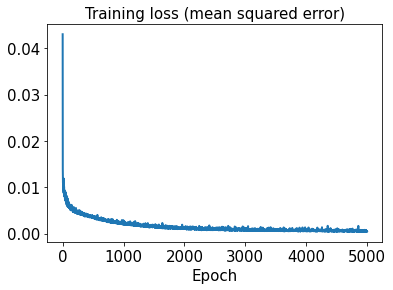

In [28]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

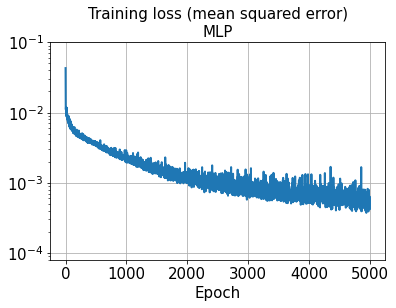

In [75]:
plt.plot(hist['loss'], lw=2)
plt.title('Training loss (mean squared error)\nMLP', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.ylim([8e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.show()

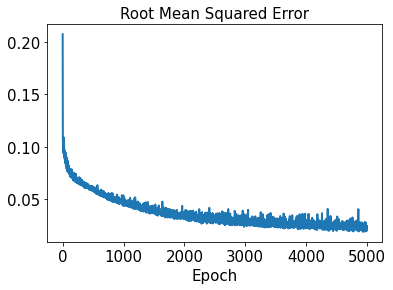

In [29]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

In [30]:
test_results = model.evaluate([x_train,aa_train])

47/47 [==============================] - 0s 2ms/step - loss: 9.5327e-06 - rmse: 0.0000e+00


In [31]:
decoded_train = model.predict([x_train,aa_train])

47/47 [==============================] - 0s 1ms/step


In [32]:
decoded_test = model.predict([x_test, aa_test])

20/20 [==============================] - 0s 2ms/step


In [33]:
error_train_abs = np.abs(decoded_train - y_train)

In [34]:
error_test_abs = np.abs(decoded_test - y_test)

In [35]:
error_train_Cl_abs = np.abs(decoded_train[:,0,:] - y_train[:,0,:])

In [36]:
error_train_Cd_abs = np.abs(decoded_train[:,1,:] - y_train[:,1,:])

In [37]:
error_test_Cl_abs = np.abs(decoded_test[:,0,:] - y_test[:,0,:])

In [38]:
error_test_Cd_abs = np.abs(decoded_test[:,1,:] - y_test[:,1,:])

In [39]:
decoded_train.shape

(1488, 2, 1)

In [40]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.03854707676040735


In [41]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.2061853448301473


In [42]:
l2_error_Cl_train = np.sqrt(np.sum((decoded_train[:,0,:] - y_train[:,0,:])**2) / np.sum(y_train[:,0,:]**2))
print(l2_error_Cl_train)

0.035037350606210056


In [43]:
l2_error_Cd_train = np.sqrt(np.sum((decoded_train[:,1,:] - y_train[:,1,:])**2) / np.sum(y_train[:,1,:]**2))
print(l2_error_Cd_train)

0.09218374467084187


In [44]:
l2_error_Cl_test = np.sqrt(np.sum((decoded_test[:,0,:] - y_test[:,0,:])**2) / np.sum(y_test[:,0,:]**2))
print(l2_error_Cl_test)

0.20377845803842123


In [45]:
l2_error_Cd_test = np.sqrt(np.sum((decoded_test[:,1,:] - y_test[:,1,:])**2) / np.sum(y_test[:,1,:]**2))
print(l2_error_Cd_test)

0.2582588747805304


In [46]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)
print(l2_error_train_list)

[0.01606666477688543, 0.015107443333509978, 0.04645239401068598, 0.3617986767826391, 0.14842080178970327, 0.007151043748203771, 0.004849567053601456, 0.01159899997100628, 0.007206293455423315, 0.00458930834330832, 0.01786533733381732, 0.03501436033154189, 0.019528172413874514, 0.017301325051371285, 0.015298885682222428, 0.009142057939735927, 0.026654885342307904, 0.03132493289912933, 0.009561825805771184, 0.045375370564259505, 0.14431400142726789, 0.03178121941275006, 0.017618336493258994, 0.018858847395297734, 0.012755994679794299, 0.008855223839210323, 0.003805534196360737, 0.02524732259149275, 0.005244558032367856, 0.019085298457933712, 0.009352788099908492, 0.007198536539149205, 0.027482911273267796, 0.022541268292376525, 0.007886614917638313, 0.013141340303296624, 0.09973484257893533, 0.09152984923406063, 0.02606525659534929, 0.0028018380598873265, 0.02748373942459109, 0.014986889694474205, 0.02696677465520554, 0.02773807873157404, 0.02036164293672789, 0.03957554131188757, 0.00665

In [47]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)
print(l2_error_test_list)

[0.023674049707411708, 0.02705454465249734, 0.08427311144932506, 0.0849628913861556, 0.08171915278709632, 0.6020156445356092, 0.05025826949010248, 0.1303863903526002, 0.10454795404890618, 0.09323770039602593, 0.23862951432756524, 0.034249434596418736, 0.04052122439095296, 0.2033243362122125, 0.2257978523388013, 0.18194210726796783, 0.13123482536239722, 0.15459834883755294, 0.1956481475213632, 0.34088929670358525, 2.846149849479586, 0.2749205020922335, 0.15545725121541326, 0.17026807601324617, 0.12828274491003575, 0.10521635040056412, 0.08489310073042716, 0.04437537945047606, 0.06658317898669591, 0.07910068623429639, 0.15074148847767277, 0.2802781344945742, 0.04266355416010304, 0.095636751458828, 0.03962198547312388, 0.022329891923294803, 0.14547265175801605, 0.6670729992924443, 0.23903940108367333, 0.21328345353682548, 0.1565902631216246, 0.04398052855973448, 0.6713806833087019, 0.2189868986144247, 0.046499497863862156, 0.3127337479161294, 0.18473928546957197, 0.1758239301805645, 0.121

In [48]:
l2_error_Cl_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cl_train_data = np.sqrt(np.sum((decoded_train[:,0,:][i] - y_train[:,0,:][i])**2) / np.sum(y_train[:,0,:][i]**2))
    l2_error_Cl_train_list.append(l2_error_Cl_train_data)
print(l2_error_Cl_train_list)

[0.003278448919755281, 0.0008064022168734624, 0.015374775009823092, 0.2853429649349371, 0.14924139969929584, 0.004992647616637911, 0.0017763067142890106, 0.006328870097340937, 0.006829652384807405, 0.0008325788730342643, 0.017858432194738563, 0.03273658909858981, 0.010219881812876683, 0.011649914534155715, 0.013649826286439624, 0.0035003096964347047, 0.023806289490082844, 0.02954560825407624, 0.009138537394204121, 0.04393892216437209, 0.12411794022254798, 0.03179426595957277, 0.013626816367664621, 0.016514256831034187, 0.009905131919499289, 0.006524817607213066, 0.002371054565797657, 0.024940354827817698, 0.0052010306718680505, 0.017121989014781066, 0.0029696409938706073, 0.003782836218854671, 0.02025097459159148, 0.017917507156685046, 0.007155391083497336, 0.012846108568476943, 0.09591398919760198, 0.06009316284444364, 0.02181767291332267, 0.0011803095606092717, 0.026201928335793857, 0.014889839011925695, 0.019274430529334717, 0.028332343075180715, 0.018069905939901286, 0.015296053315

In [49]:
l2_error_Cd_train_list = []
for i in range(0, len(aa_train)):
    l2_error_Cd_train_data = np.sqrt(np.sum((decoded_train[:,1,:][i] - y_train[:,1,:][i])**2) / np.sum(y_train[:,1,:][i]**2))
    l2_error_Cd_train_list.append(l2_error_Cd_train_data)
print(l2_error_Cd_train_list)

[0.35522005932762607, 0.3263224745846535, 0.6586793725630822, 1.016849057313855, 0.06683126340361083, 0.1072067767446653, 0.13852476048248097, 0.35173273130175764, 0.0843970522320164, 0.14865506113113447, 0.022403675886236388, 0.2816384348196011, 0.3007821298261925, 0.17793407949257042, 0.08376924381109652, 0.0753692788391315, 0.27141034681094356, 0.2720717082649928, 0.06923467439702835, 0.19459563440478322, 0.41245201660123726, 0.03103702224329858, 0.21464885984639231, 0.25025415786225114, 0.24404243156879152, 0.16689797170961004, 0.06674281679356321, 0.07428120429193805, 0.01036982095703077, 0.0974985899586866, 0.07874568527360193, 0.04332231415455121, 0.08274446606804318, 0.08288674558492691, 0.04206298503335783, 0.053807992950272575, 0.2786476039626221, 0.4288656606085627, 0.29951951178723896, 0.07862836927540352, 0.25066439288691494, 0.031248363684523557, 0.18493517629996398, 0.011078525289273531, 0.03899280296320757, 0.11830570440796483, 0.0013681670676401825, 0.05140351861870457

In [50]:
l2_error_Cl_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cl_test_data = np.sqrt(np.sum((decoded_test[:,0,:][i] - y_test[:,0,:][i])**2) / np.sum(y_test[:,0,:][i]**2))
    l2_error_Cl_test_list.append(l2_error_Cl_test_data)
print(l2_error_Cl_test_list)

[0.022302705646581242, 0.026975187637441948, 0.08322170232208834, 0.0849350873239133, 0.08053217590348094, 0.6114713094980847, 0.050253483421461576, 0.13044561640222496, 0.1045022656996627, 0.09231490064062307, 0.24137655685569762, 0.029830240801737688, 0.04130275074248143, 0.1970668128086689, 0.22876743786022832, 0.18985228958123143, 0.1312632275441153, 0.154686050844798, 0.1954587485450494, 0.33957456448486967, 4.100747786448697, 0.27479065660675944, 0.15471008913884285, 0.169408749448346, 0.12716539651718192, 0.10523708002513761, 0.08470085446097993, 0.04268893513259429, 0.06570486391659695, 0.07432221756061173, 0.153679300203535, 0.2702427649218383, 0.04093631769725389, 0.08567898759412262, 0.037630239566552204, 0.021875682167877594, 0.14103102253981836, 0.6716898195286256, 0.23894864892148132, 0.21293927729289006, 0.1559681801563273, 0.03403287088722798, 0.6724691786584285, 0.22442996227653425, 0.044699608823324515, 0.3162124117751728, 0.18955398876325288, 0.16779420492954672, 0.1

In [51]:
l2_error_Cd_test_list = []
for i in range(0, len(aa_test)):
    l2_error_Cd_test_data = np.sqrt(np.sum((decoded_test[:,1,:][i] - y_test[:,1,:][i])**2) / np.sum(y_test[:,1,:][i]**2))
    l2_error_Cd_test_list.append(l2_error_Cd_test_data)
print(l2_error_Cd_test_list)

[0.04202027261787608, 0.02972327164852465, 0.19595933315574715, 0.094433395688125, 0.15853033688910642, 0.24718511413186509, 0.05221409539556878, 0.06486828211616306, 0.12851712348952493, 0.20468173912508564, 0.12458446470422453, 0.07930070521075312, 0.028710863587157683, 0.2558967274421356, 0.1992173872957687, 0.11812372195051847, 0.10144816153980445, 0.0022754698442175136, 0.2843496548350369, 0.5372814706135971, 0.056021606192450626, 0.2952563194404922, 0.4181525365376149, 0.6286034978474186, 0.7047034573231249, 0.05895477828599653, 0.23191216805238687, 0.36300202848839813, 0.21476936395222243, 0.2831267471336198, 0.03860275137481491, 0.3299534200227064, 0.06657919803312654, 0.28621167236669204, 0.1937294580657368, 0.09856803846903779, 0.409278072573079, 0.5426696637803133, 0.2734564452258588, 0.4306368168887548, 0.4923209410220467, 0.5849998638611399, 0.5826223060200227, 0.034439582138755066, 0.06677880850872264, 0.269506015656215, 0.1351781463300615, 0.22473522311493818, 0.05753527

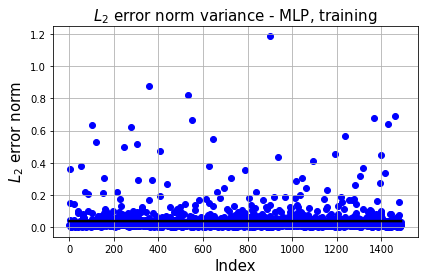

In [52]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - MLP, training', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

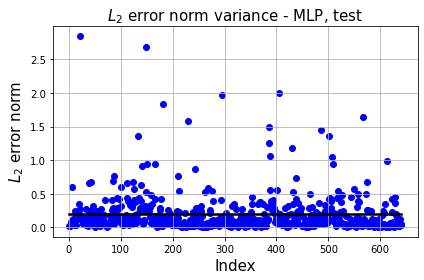

In [53]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - MLP, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

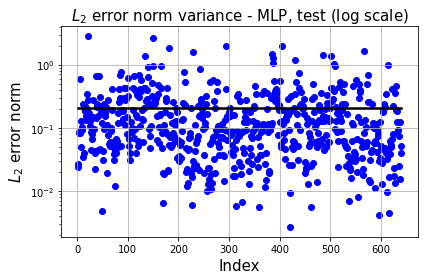

In [54]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - MLP, test (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

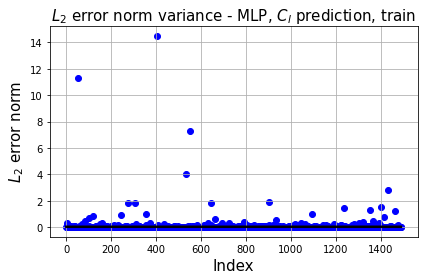

In [55]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - MLP, $C_l$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

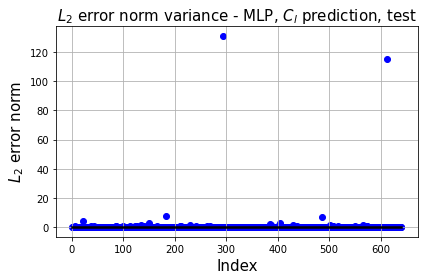

In [56]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.title('$L_2$ error norm variance - MLP, $C_l$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

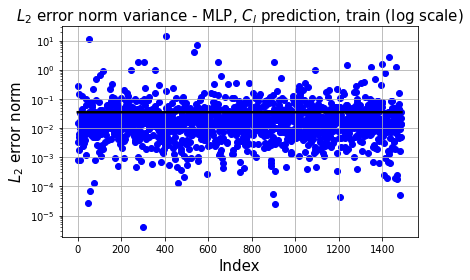

In [57]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cl_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cl_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - MLP, $C_l$ prediction, train (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

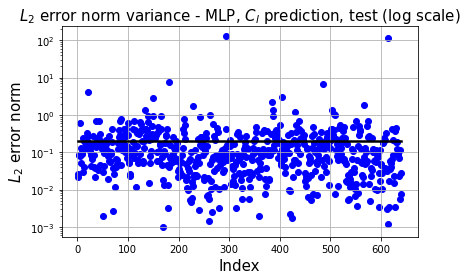

In [58]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cl_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cl_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - MLP, $C_l$ prediction, test (log scale)', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

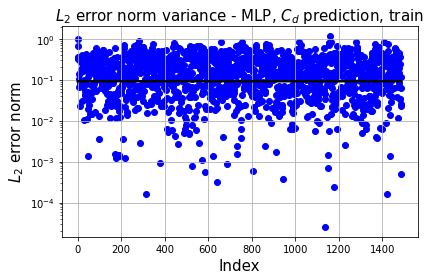

In [77]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_Cd_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_Cd_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - MLP, $C_d$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

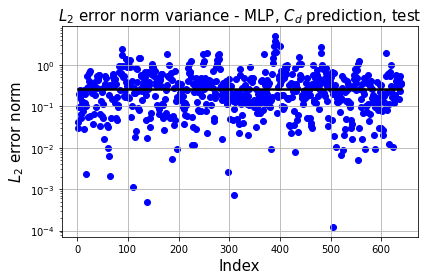

In [76]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_Cd_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_Cd_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm variance - MLP, $C_d$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

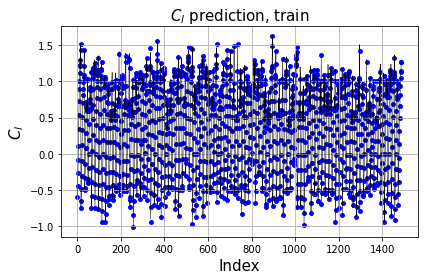

In [61]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,0,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

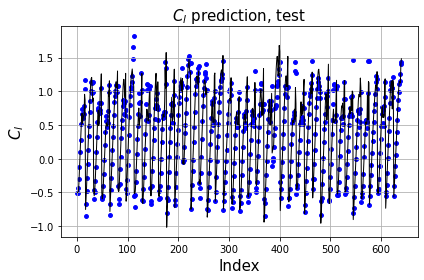

In [62]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,0,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,0,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.title(r'$C_l$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

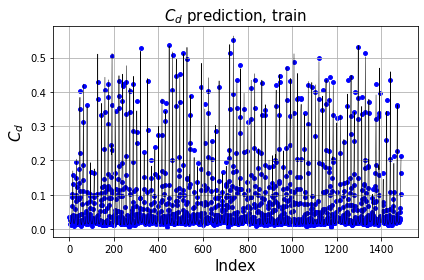

In [63]:
plt.plot(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), y_train[:,1,:], 'k',lw=0.5)
plt.scatter(np.linspace(1, decoded_train.shape[0], decoded_train.shape[0]), decoded_train[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, train', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

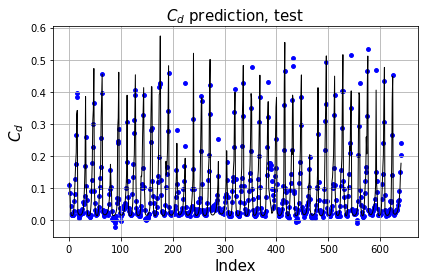

In [64]:
plt.plot(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), y_test[:,1,:], 'k',lw=1)
plt.scatter(np.linspace(1, decoded_test.shape[0], decoded_test.shape[0]), decoded_test[:,1,:], c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.title(r'$C_d$ prediction, test', fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

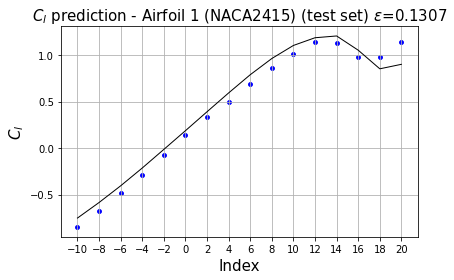

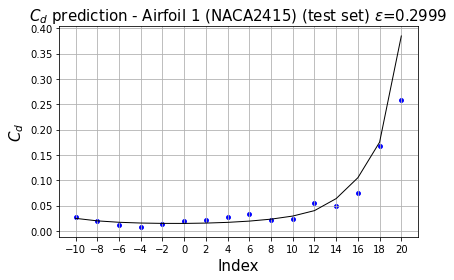

In [92]:
airfoiltest1_predict = decoded_test[16*1:16*2]

airfoiltest1_cl=y_test[16*1:16*2,0,:]
airfoiltest1_cd=y_test[16*1:16*2,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCl), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 1 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[1*16][0])[2:-1], epsilonCd), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

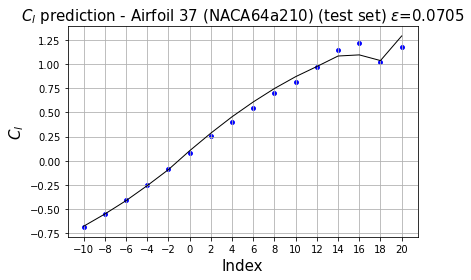

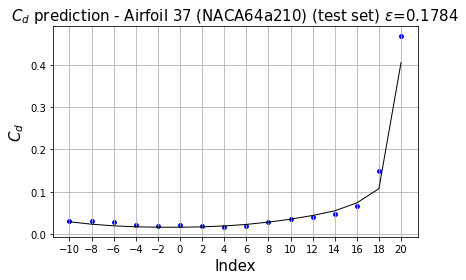

In [90]:
airfoiltest37_predict = decoded_test[16*36:16*37]

airfoiltest37_cl=y_test[16*36:16*37,0,:]
airfoiltest37_cd=y_test[16*36:16*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest37_predict[:,0,:] - airfoiltest37_cl)**2) / np.sum(airfoiltest37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest37_predict[:,1,:] - airfoiltest37_cd)**2) / np.sum(airfoiltest37_cd**2))

plt.plot(alpha, airfoiltest37_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest37_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 37 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[37*16][0])[2:-1], epsilonCl), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest37_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest37_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 37 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[37*16][0])[2:-1], epsilonCd), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

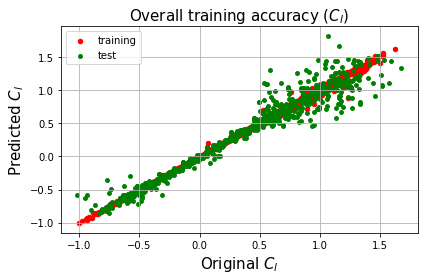

In [70]:
plt.scatter(y_train[:,0,:], decoded_train[:,0,:], c='r', s=20)
plt.scatter(y_test[:,0,:], decoded_test[:,0,:], c='g', s=15)
plt.xlabel('Original $C_l$', fontsize=15)
plt.ylabel('Predicted $C_l$', fontsize=15)
plt.title('Overall training accuracy ($C_l$)', fontsize=15)

plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

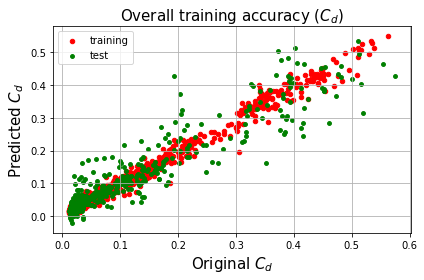

In [71]:
plt.scatter(y_train[:,1,:], decoded_train[:,1,:], c='r', s=20)
plt.scatter(y_test[:,1,:], decoded_test[:,1,:], c='g', s=15)
plt.xlabel('Original $C_d$', fontsize=15)
plt.ylabel('Predicted $C_d$', fontsize=15)
plt.title('Overall training accuracy ($C_d$)', fontsize=15)
plt.grid()
plt.legend(['training', 'test'])
plt.tight_layout()
plt.show()

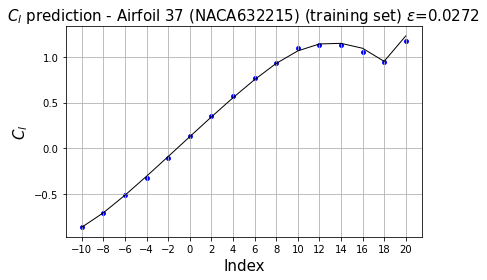

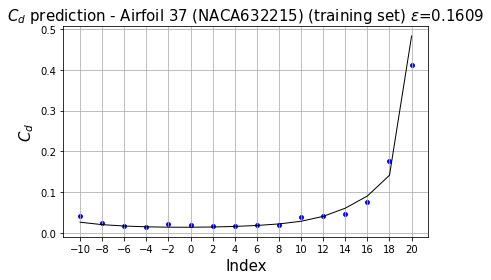

In [78]:
airfoiltrain37_predict = decoded_train[16*36:16*37]

airfoiltrain37_cl=y_train[16*36:16*37,0,:]
airfoiltrain37_cd=y_train[16*36:16*37,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain37_predict[:,0,:] - airfoiltrain37_cl)**2) / np.sum(airfoiltrain37_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain37_predict[:,1,:] - airfoiltrain37_cd)**2) / np.sum(airfoiltrain37_cd**2))

plt.plot(alpha, airfoiltrain37_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltrain37_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_l$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCl), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain37_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltrain37_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title('$C_d$ prediction - Airfoil 37 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[36*16][0])[2:-1], epsilonCd), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

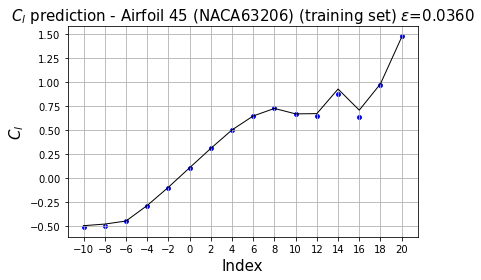

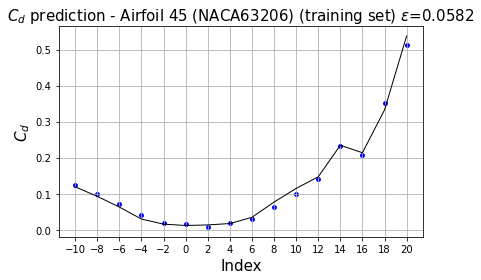

In [79]:
airfoiltrain45_predict = decoded_train[16*44:16*45]

airfoiltrain45_cl=y_train[16*44:16*45,0,:]
airfoiltrain45_cd=y_train[16*44:16*45,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltrain45_predict[:,0,:] - airfoiltrain45_cl)**2) / np.sum(airfoiltrain45_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltrain45_predict[:,1,:] - airfoiltrain45_cd)**2) / np.sum(airfoiltrain45_cd**2))

plt.plot(alpha, airfoiltrain45_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltrain45_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCl),
          fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltrain45_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltrain45_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 45 (%s) (training set) $\epsilon$=%.4f' % (str(geo_train[44*16][0])[2:-1], epsilonCd),
          fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

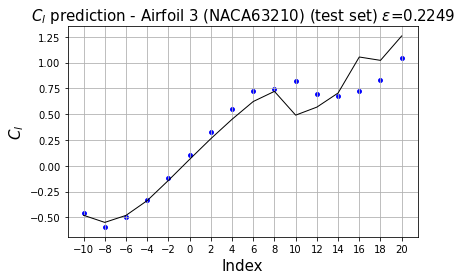

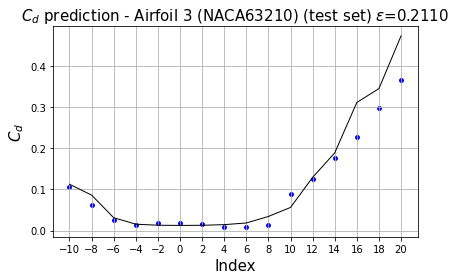

In [93]:
airfoiltest1_predict = decoded_test[16*2:16*3]

airfoiltest1_cl=y_test[16*2:16*3,0,:]
airfoiltest1_cd=y_test[16*2:16*3,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCl), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 3 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[2*16][0])[2:-1], epsilonCd), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

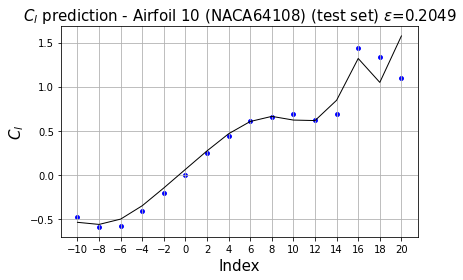

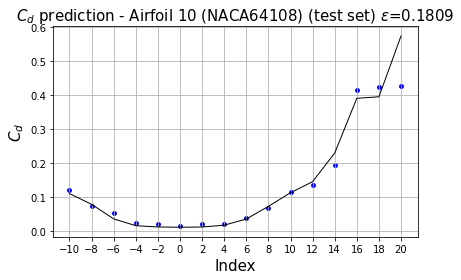

In [94]:
airfoiltest1_predict = decoded_test[16*10:16*11]

airfoiltest1_cl=y_test[16*10:16*11,0,:]
airfoiltest1_cd=y_test[16*10:16*11,1,:]

epsilonCl = np.sqrt(np.sum((airfoiltest1_predict[:,0,:] - airfoiltest1_cl)**2) / np.sum(airfoiltest1_cl**2))
epsilonCd = np.sqrt(np.sum((airfoiltest1_predict[:,1,:] - airfoiltest1_cd)**2) / np.sum(airfoiltest1_cd**2))

plt.plot(alpha, airfoiltest1_cl.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,0,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_l$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_l$ prediction - Airfoil 10 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[10*16][0])[2:-1], epsilonCl), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

plt.plot(alpha, airfoiltest1_cd.reshape(16,), 'k', lw=1)
plt.scatter(alpha, airfoiltest1_predict[:,1,:].reshape(16,), c='b', s=15)
plt.xlabel('Index', fontsize=15)
plt.ylabel('$C_d$', fontsize=15)
plt.xticks(alpha, label=alpha)
plt.title(r'$C_d$ prediction - Airfoil 10 (%s) (test set) $\epsilon$=%.4f' % (str(geo_test[10*16][0])[2:-1], epsilonCd), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()